this is a classification problem and we got original data which contains 5 features and 3 labels, each pixel can regarded as a sample

# 1.Frame the problem

# 2.Input the data

In [3]:
#all packages which will be used
import numpy as np
import pandas as pd
from scipy.io import loadmat
import time
import random
import re

#plot
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from matplotlib.axes import Axes

#sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

#from sklearn.cluster import KMeans
from sklearn import neighbors
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
#from sklearn.metrics import precision_score, recall_score,f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.kernel_approximation import RBFSampler #change the linear kernel into RBF
#to plot more than 2 dimensions 
from mlxtend.plotting import plot_decision_regions

#scipy
from scipy.stats import chisquare
from scipy.stats import chi2
from scipy.spatial import distance

#good performance classifier
from xgboost import XGBClassifier

#Tensorflow
import tensorflow as tf


#math
from math import log

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



first we imported the data from the '.mat'

In [2]:
#import the dataset
dataset = loadmat ("C:\\Users\\hasee\\workspace\\lab\patRecDat\\forStudents\\medData\\dataset.mat",mat_dtype=True)
#dataset = loadmat ("D:\\lab; signal processing\\forStudents\\medData\\dataset.mat",mat_dtype=True)

In [3]:
#import key'dataset' from dict
data=dataset["dataset"]

then we try to plot one image to see what it looks like

In [4]:
data[12][0][0][0][3].shape
#for element in data[12][0][0][0][1][:,:,20].flat:
    #assert element == 0

(320, 320, 43)

In [6]:
#see the dimension of each stuck
for i in range(len(data)):
    print(data[i][0][0][0][0][:,:,:,1].shape)
    
len(data)

(34, 41, 31)
(80, 82, 82)
(82, 74, 80)
(89, 102, 85)
(66, 78, 62)
(69, 83, 66)
(50, 57, 48)
(55, 69, 54)
(64, 65, 63)
(99, 83, 80)
(107, 99, 85)
(320, 320, 39)
(320, 320, 43)
(320, 320, 39)


14

In [8]:
#see total voxels
sum = 0
for i in range (len(data)):
    sum = sum + data[i][0][0][0][0].size
sum    

85436685

In [9]:
def plot_image(data,stuck,slices,features,alphapara,cmap):
    target_data=data[stuck][0][0][0][0][:,:,slices,features]
    target_image=target_data.reshape(target_data.shape[0],target_data.shape[1])
    plt.imshow(target_image,cmap,alpha=alphapara)
    plt.axis("off") #close the axis number

In [10]:
def plot_setimage(stuck,slices):
    features = 0
    plt.figure(figsize=(8,4))
    alphapara = 1;
    cmap = matplotlib.cm.binary
    plt.subplot(151)
    plt.title("T2 weighted")
    plot_image(data,stuck,slices,features,alphapara,cmap)
    plt.show()

    plt.subplot(152)
    plt.title("ADC")
    plot_image(data,stuck,slices,features+1,alphapara,cmap)
    plt.show()

    plt.subplot(153)
    plt.title("Ktrans")
    plot_image(data,stuck,slices,features+2,alphapara,cmap)
    plt.show()

    plt.subplot(154)
    plt.title("Kep")
    plot_image(data,stuck,slices,features+3,alphapara,cmap)
    plt.show()

    plt.subplot(155)
    plt.title("PET")
    plot_image(data,stuck,slices,features+4,alphapara,cmap)
    plt.show()

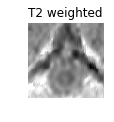

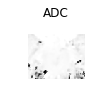

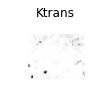

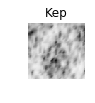

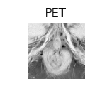

In [12]:
#visulize the each feature of one sample
stuck,slices= 1, 12
plot_setimage(stuck,slices)

then we try to find out the labels distribution

then we try to use a function to plot the prostate and cancer area on the feature image

In [14]:
cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list('my_cmap',['black','red','blue'],256)
def plot_all(data,stuck,index,slices,features):
    target_data=data[stuck][0][0][0][0][:,:,slices,features]
    target_image1=target_data.reshape(target_data.shape[0],target_data.shape[1])
    target_label=data[stuck][0][0][0][index][:,:,slices]
    target_image2=target_label.reshape(target_label.shape[0],target_label.shape[1])
    plt.imshow(target_image1,cmap = matplotlib.cm.binary,alpha=0.8)
    plt.imshow(target_image2,cmap = cmap1,interpolation="bilinear",alpha=0.2)
    plt.axis("off") #close the axis number

plot the prostate area and the cancer area

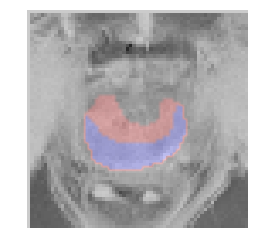

In [16]:
stuck,slices,index,features=8,24,1,4
#plot_image(data,stuck,slices,0)
#plot_label(data,stuck,2,slices)
plot_all(data,stuck,index,slices,features)
plt.show()

# 3. Exploring the features

## 3.1 Extract prostate region

we can find that 1-11 strucks are expected by experts and 12-14 are histological analysis because it is more reliable than the experts,and later 1-11 strucks will be out training set and 12-14 will be out validation set

In [17]:
'''
#extract prostate area from the original map 
experts_num,histo_num=11,3
label_final=[]
for i in range(experts_num):
    labelA=data[i][0][0][0][1]
    labelB=data[i][0][0][0][2]
    for index,(item_A,item_B) in enumerate(zip(labelA.flat,labelB.flat)):
        #use enumerate to iterate the items in labelA and labelB respectively
                if item_A == item_B:
                    pass
                else:
                    labelA.flat[index]=0
    label_final.append(labelA)
'''

'\n#extract prostate area from the original map \nexperts_num,histo_num=11,3\nlabel_final=[]\nfor i in range(experts_num):\n    labelA=data[i][0][0][0][1]\n    labelB=data[i][0][0][0][2]\n    for index,(item_A,item_B) in enumerate(zip(labelA.flat,labelB.flat)):\n        #use enumerate to iterate the items in labelA and labelB respectively\n                if item_A == item_B:\n                    pass\n                else:\n                    labelA.flat[index]=0\n    label_final.append(labelA)\n'

then append the histological struck

In [18]:
'''
#for the 
for j in range(histo_num):
    labelC=data[j+11][0][0][0][3]
    label_final.append(labelC)

label=np.array(label_final)
label.shape
'''

'\n#for the \nfor j in range(histo_num):\n    labelC=data[j+11][0][0][0][3]\n    label_final.append(labelC)\n\nlabel=np.array(label_final)\nlabel.shape\n'

then our task divided into two parts:
- isolate the feature vector of prostate tissure from the whole set
- try to transfer first feature TR wighted MR images

then let us create train data set and validation set respectively

In [19]:
'''
train_data=data[:experts_num]
train_label=label[:experts_num]
val_data=data[:-experts_num]
val_label=label[:-experts_num]
val_label.shape
'''

'\ntrain_data=data[:experts_num]\ntrain_label=label[:experts_num]\nval_data=data[:-experts_num]\nval_label=label[:-experts_num]\nval_label.shape\n'

In [20]:
'''
train_isolated_feature=[]
train_isolated_label=[]
val_isolated_feature=[]
val_isolated_label=[]
def isolate_feature(data,label,isolated_feature,isolated_label):
    for i in range(len(data)):
        image=data[i][0][0][0][0]
        target_image=image.reshape(image.shape[0]*image.shape[1]*image.shape[2],image.shape[3])
        target_label=label[i].reshape(-1,1)
        for index,item in enumerate(target_label):
            if item == 0 :
                pass
            else:
                isolated_label.append(item)
                isolated_feature.append(target_image[index])
    return isolated_feature,isolated_label
        

isolate_feature(train_data,train_label,train_isolated_feature,train_isolated_label)
isolate_feature(val_data,val_label,val_isolated_feature,val_isolated_label)

print(len(train_isolated_feature))
'''

'\ntrain_isolated_feature=[]\ntrain_isolated_label=[]\nval_isolated_feature=[]\nval_isolated_label=[]\ndef isolate_feature(data,label,isolated_feature,isolated_label):\n    for i in range(len(data)):\n        image=data[i][0][0][0][0]\n        target_image=image.reshape(image.shape[0]*image.shape[1]*image.shape[2],image.shape[3])\n        target_label=label[i].reshape(-1,1)\n        for index,item in enumerate(target_label):\n            if item == 0 :\n                pass\n            else:\n                isolated_label.append(item)\n                isolated_feature.append(target_image[index])\n    return isolated_feature,isolated_label\n        \n\nisolate_feature(train_data,train_label,train_isolated_feature,train_isolated_label)\nisolate_feature(val_data,val_label,val_isolated_feature,val_isolated_label)\n\nprint(len(train_isolated_feature))\n'

In [45]:
experts_num,histo_num=11,3
train_index_matrix = []
train_isolated_feature0=[]
train_isolated_feature1=[]
train_isolated_feature2=[]
train_isolated_feature3=[]
train_isolated_feature4=[]
train_isolated_label=[]
train_sourceofpixels = []
for i in range(experts_num):
    
    # feature vecotr for each stuck
    feature0 = data [i][0][0][0][0][:,:,:,0]
    feature1 = data [i][0][0][0][0][:,:,:,1]
    feature2 = data [i][0][0][0][0][:,:,:,2]
    feature3 = data [i][0][0][0][0][:,:,:,3]
    feature4 = data [i][0][0][0][0][:,:,:,4]
    
    #A is the doctor A, B is the doctor B
    tempA = data[i][0][0][0][1]
    tempB = data[i][0][0][0][2]
    ita = np.nditer(tempA, flags =['multi_index'])
    itb = np.nditer(tempB, flags =['multi_index'])
    
    #iterator for the features
    itf0 = np.nditer(feature0,flags =['multi_index'])
    itf1 = np.nditer(feature1,flags =['multi_index'])
    itf2 = np.nditer(feature2,flags =['multi_index'])
    itf3 = np.nditer(feature3,flags =['multi_index'])
    itf4 = np.nditer(feature4,flags =['multi_index'])
    while not ita.finished:
        if ((ita[0]==1)&(itb[0]==1)) or ((ita[0]==2)&(itb[0]==2)):
            train_isolated_feature0.append(itf0[0])
            train_isolated_feature1.append(itf1[0])
            train_isolated_feature2.append(itf2[0])
            train_isolated_feature3.append(itf3[0])
            train_isolated_feature4.append(itf4[0])
            train_isolated_label.append(ita[0])
            train_index_matrix.append(np.array(ita.multi_index))
            train_sourceofpixels.append(i)
        else:
            pass
        '''    
        elif((ita[0] == 1)&(itb[0]== 2)):
            train_isolated_feature0.append(itf0[0])
            train_isolated_feature1.append(itf1[0])
            train_isolated_feature2.append(itf2[0])
            train_isolated_feature3.append(itf3[0])
            train_isolated_feature4.append(itf4[0])
            train_isolated_label.append(ita[0])
            train_index_matrix.append(np.array(ita.multi_index))
            train_sourceofpixels.append(i)
        elif((ita[0] ==2) & (itb[0]==1)):
            train_isolated_feature0.append(itf0[0])
            train_isolated_feature1.append(itf1[0])
            train_isolated_feature2.append(itf2[0])
            train_isolated_feature3.append(itf3[0])
            train_isolated_feature4.append(itf4[0])
            train_isolated_label.append(itb[0])
            train_index_matrix.append(np.array(ita.multi_index))
            train_sourceofpixels.append(i)
        ''' 
        itf0.iternext()
        itf1.iternext()
        itf2.iternext()
        itf3.iternext()
        itf4.iternext()
        itb.iternext()
        ita.iternext()

In [48]:
tempdic_train = {'label':train_isolated_label, 'stuck_num':train_sourceofpixels, 'pixel_index':train_index_matrix,'feature0':train_isolated_feature0,'feature1':train_isolated_feature1,'feature2':train_isolated_feature2,'feature3':train_isolated_feature3,'feature4':train_isolated_feature4}
train_data= pd.DataFrame(data=tempdic_train)

In [53]:
train_feature=train_data[['feature0','feature1','feature2','feature3','feature4']]

In [54]:
train_label= train_data[['label','pixel_index','stuck_num']]

In [55]:
train_label

,label,pixel_index,stuck_num
0,1.0,"[9, 10, 0]",0
1,1.0,"[10, 10, 0]",0
2,1.0,"[11, 10, 0]",0
3,1.0,"[12, 10, 0]",0
4,1.0,"[13, 10, 0]",0
5,1.0,"[14, 10, 0]",0
6,1.0,"[15, 10, 0]",0
7,1.0,"[16, 10, 0]",0
8,1.0,"[6, 11, 0]",0
9,1.0,"[7, 11, 0]",0


In [56]:
validation_index_matrix = []
validation_isolated_feature0=[]
validation_isolated_feature1=[]
validation_isolated_feature2=[]
validation_isolated_feature3=[]
validation_isolated_feature4=[]
validation_isolated_label=[]
validation_sourceofpixel = []
for i in range(histo_num):
    temp_label = data[i+11][0][0][0][3]
    temp_feature0 = data[i+11][0][0][0][0][:,:,:,0]
    temp_feature1 = data[i+11][0][0][0][0][:,:,:,1]
    temp_feature2 = data[i+11][0][0][0][0][:,:,:,2]
    temp_feature3 = data[i+11][0][0][0][0][:,:,:,3]
    temp_feature4 = data[i+11][0][0][0][0][:,:,:,4]
    it_label = np.nditer(temp_label, flags=['multi_index'])
    it_feature0 = np.nditer(temp_feature0, flags=['multi_index'])
    it_feature1 = np.nditer(temp_feature1, flags=['multi_index'])
    it_feature2 = np.nditer(temp_feature2, flags=['multi_index'])
    it_feature3 = np.nditer(temp_feature3, flags=['multi_index'])
    it_feature4 = np.nditer(temp_feature4, flags=['multi_index'])
    while not it_label.finished:
        if (it_label[0] != 0 ):
            validation_isolated_feature0.append(it_feature0[0])
            validation_isolated_feature1.append(it_feature1[0])
            validation_isolated_feature2.append(it_feature2[0])
            validation_isolated_feature3.append(it_feature3[0])
            validation_isolated_feature4.append(it_feature4[0])
            validation_isolated_label.append(it_label[0])
            validation_index_matrix.append(np.array(it_label.multi_index))
            validation_sourceofpixel.append(i+11)
        else:
            pass
        it_feature0.iternext()
        it_feature1.iternext()
        it_feature2.iternext()
        it_feature3.iternext()
        it_feature4.iternext()
        it_label.iternext()    

In [57]:
tempdic_validation = {'label':validation_isolated_label , 'stuck_num':validation_sourceofpixel, 'pixel_index':validation_index_matrix,'feature0':validation_isolated_feature0,'feature1':validation_isolated_feature1,'feature2':validation_isolated_feature2,'feature3':validation_isolated_feature3,'feature4':validation_isolated_feature4}
validation_data = pd.DataFrame(data=tempdic_validation)

In [58]:
validation_label= validation_data[['label','pixel_index','stuck_num']]

In [59]:
validation_feature=validation_data[['feature0','feature1','feature2','feature3','feature4']]

save the train set and validation set

In [66]:
train_feature.to_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\train_feature.csv",index=False)
train_label.to_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\train_label.csv",index=False)
validation_feature.to_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\validation_feature.csv",index=False)
validation_label.to_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\validation_label.csv",index=False)
#train_feature.to_csv("D:\\lab; signal processing\\forStudents\\medData\\train_feature.csv",index=True)
#train_label.to_csv("D:\\lab; signal processing\\forStudents\\medData\\train_label.csv",index=True)
#validation_feature.to_csv("D:\\lab; signal processing\\forStudents\\medData\\validation_feature.csv",index=True)
#validation_label.to_csv("D:\\lab; signal processing\\forStudents\\medData\\validation_label.csv",index=True)

## 3.2 Normalization & Outliers detection

so we see we isolated the 355455 prostate features from the 4696937 the whole train set

then try to construct the whole pipeline of the features enginerring
- Transform the first feature TR wighted
- normalize all the features
- Outlier detection and removal

In [4]:
X_train=pd.read_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\train_feature.csv")
y_train=pd.read_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\train_label.csv")
X_val=pd.read_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\validation_feature.csv")
y_val=pd.read_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\validation_label.csv")
#X_train=pd.read_csv("D:\\lab; signal processing\\forStudents\\medData\\train_feature.csv")
#y_train=pd.read_csv("D:\\lab; signal processing\\forStudents\\medData\\train_label.csv")
#X_val=pd.read_csv("D:\\lab; signal processing\\forStudents\\medData\\validation_feature.csv")
#y_val=pd.read_csv("D:\\lab; signal processing\\forStudents\\medData\\validation_label.csv")

In [5]:
scaler1=MinMaxScaler(feature_range=(0, 1), copy=True)
class Feature_scaling(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        scaler1.fit(np.array(X['feature0']).reshape(-1,1))
        return self
    def transform(self,X,y=None):
        X['feature0']=scaler1.transform(np.array(X['feature0']).reshape(-1,1))
        return X

In [6]:
scaler2=StandardScaler()
class Normalization(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        scaler2.fit(X[['feature0','feature1','feature2','feature3','feature4']])
        return self
    def transform(self,X,y=None):
        X[['feature0','feature1','feature2','feature3','feature4']]=scaler2.transform(X[['feature0','feature1','feature2','feature3','feature4']])
        return pd.DataFrame(X)

In [7]:
feature_eng=Pipeline([("feature_scale",Feature_scaling()),
                     ("normalization",Normalization())])

In [8]:
X_train_scaled=feature_eng.fit_transform(X_train)
X_train_scaled

,feature0,feature1,feature2,feature3,feature4
0,0.387046,0.286907,-0.298482,-0.671537,-1.611109
1,0.117651,0.285209,-0.302723,-0.624315,-1.479327
2,0.147586,0.221792,-0.305188,-0.571669,-1.616350
3,0.147843,0.130994,-0.304649,-0.559207,-1.440395
4,0.285163,0.079095,-0.304922,-0.578629,-1.689022
5,0.248917,0.018793,-0.308985,-0.630179,-1.620275
6,0.315321,-0.065230,-0.311815,-0.679857,-1.797061
7,0.377850,-0.134095,-0.312235,-0.653669,-1.710650
8,1.447649,0.349727,-0.295720,-0.879661,-0.336726
9,1.259228,0.245014,-0.304999,-0.889284,-0.615679


In [9]:
#X_train_scaled=feature_eng.fit_transform(X_train.drop('Unnamed: 0',1))
X_val_scaled=feature_eng.transform(X_val)

In [10]:
X_val_scaled

,feature0,feature1,feature2,feature3,feature4
0,1.496713,-0.508974,-0.266269,-0.708827,0.480083
1,1.493759,-0.549401,-0.243492,-0.774610,0.952082
2,0.229118,-0.260003,-0.285134,-0.441109,2.077617
3,0.558443,-0.086173,-0.267538,-0.495074,0.719713
4,0.833441,0.024761,-0.256189,-0.540253,-0.100838
5,1.140704,-0.006060,-0.250115,-0.581308,0.654360
6,1.464060,-0.016312,-0.236356,-0.624755,1.358727
7,1.662426,-0.096102,-0.216974,-0.682210,2.244632
8,1.683592,-0.201589,-0.201712,-0.750188,2.847339
9,2.002994,-0.292518,-0.185280,-0.807845,3.159584


In [11]:
#X_val_scaled.to_csv("D:\\lab; signal processing\\forStudents\\medData\\scaled_validation_feature.csv",index=True)
#_val.to_csv("D:\\lab; signal processing\\forStudents\\medData\\validation_label.csv",index=False)
X_val_scaled.to_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\scaled_validation_feature.csv",index=False)
y_val.to_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\validation_label.csv",index=False)

In [12]:
#scaled transform and X_val and outpuy X_val
#X_val_scaled=feature_eng.transform(X_val)
#X_val_scaled.to_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\val_feature.csv",index=False)
#y_val.to_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\val_label.csv",index=False)

now, we try to apply the outliers detection first try the chi-square distribution$$\chi^2=\sum\frac{(A-E)^2}{E}$$

**there are two ways to approxiamte the MVE(minimum volume elliposid estimator)**
- the resampling algorithm
- the projection algorithm

we can wirte three approxiamtion respectively,first calculate **mahalanbios distance** $$MD_i=\sqrt{(x_i-\mu)C^{-1}(x_i-\mu)^T}$$
and after we get chi value of $MD$ we have can calculate $RD$(Robust distances) in the same equation but different approximation

In [13]:
class outliers_clean_direct(BaseEstimator,TransformerMixin):
    def __init__(self,p_free,labels,md_dis=pd.Series([]),y_dropped=pd.Series([]),p_value=0.):
        self.md_dis=md_dis
        self.y_dropped=labels
        self.p_value=p_value
        self.p_free=p_free
        self.labels=labels
    def fit(self,X,y=None):
        mean_value=np.array([X.mean()])
        covar_value=np.mat(X.cov().as_matrix()).I
        print("MD Start")
        self.md_dis=distance.cdist(X,mean_value,metric='mahalanobis',VI=covar_value).ravel()
        print("MD end")
        chi2.fit(self.md_dis,self.p_free)
        self.p_value=np.sqrt(chi2.ppf(0.975,self.p_free))
        return self
    def transform(self,X,y=None): #should be changed to y_train
        count,count1,count2=0,0,0
        count1=X.shape[0]
        print("mahalanbios distance: ",self.md_dis)
        print("cutoff value: ",self.p_value)
        print("Drop Start")
        self.md_dis=pd.DataFrame(self.md_dis,columns=['maha_dis'])
        X=pd.concat([X,self.md_dis],axis=1)
        self.labels=pd.concat([self.labels,self.md_dis],axis=1)
        X=X[X['maha_dis']<=self.p_value]
        self.y_dropped=self.labels[self.labels['maha_dis']>self.p_value]
        self.labels=self.labels[self.labels['maha_dis']<=self.p_value]
        X=pd.DataFrame.reset_index(X).drop('index',axis=1)
        self.labels=pd.DataFrame.reset_index(self.labels).drop('index',axis=1)
        self.y_dropped=pd.DataFrame.reset_index(self.y_dropped).drop('index',axis=1)
        count2=X.shape[0]
        count=count1-count2
        print("Drop End")
        print("drop count:",count)
        return X,self.labels,self.y_dropped,self.md_dis

In [14]:
#plot the distance to visualize the outliers
def plot_outliers(maha_dis,cdf1,cdf2,cdf3):
    x=range(len(maha_dis))
    plt.figure(figsize=(16,12))
    plt.scatter( x, maha_dis ,s=1)

    plt.hlines( np.sqrt(chi2.ppf(cdf1, 5)), 0, len(maha_dis), label ="%5f $\chi^2$ quantile"%(cdf1), linestyles = "solid" ) 
    plt.hlines( np.sqrt(chi2.ppf(cdf2, 5)), 0, len(maha_dis), label ="%5f $\chi^2$ quantile"%(cdf2), linestyles="dashed" ) 
    plt.hlines( np.sqrt(chi2.ppf(cdf3, 5)), 0, len(maha_dis), label ="%5f $\chi^2$ quantile"%(cdf3), linestyles = "dotted" )

    plt.legend()
    plt.ylabel("recorded value",fontsize=20)
    plt.xlabel("observation",fontsize=20)
    plt.title( 'Detection of outliers at different $\chi^2$ quantiles',fontsize=25 )

    plt.show()

In [15]:
X_train_direct,y_train_direct,y_directlydropped,maha_dis=outliers_clean_direct(p_free=5,labels=y_train.copy()).fit_transform(X_train_scaled)

MD Start
MD end
mahalanbios distance:  [ 2.1662908   1.92628241  2.00676683 ...,  1.06972045  2.09246281
  0.68770883]
cutoff value:  3.58224817594
Drop Start
Drop End
drop count: 23139


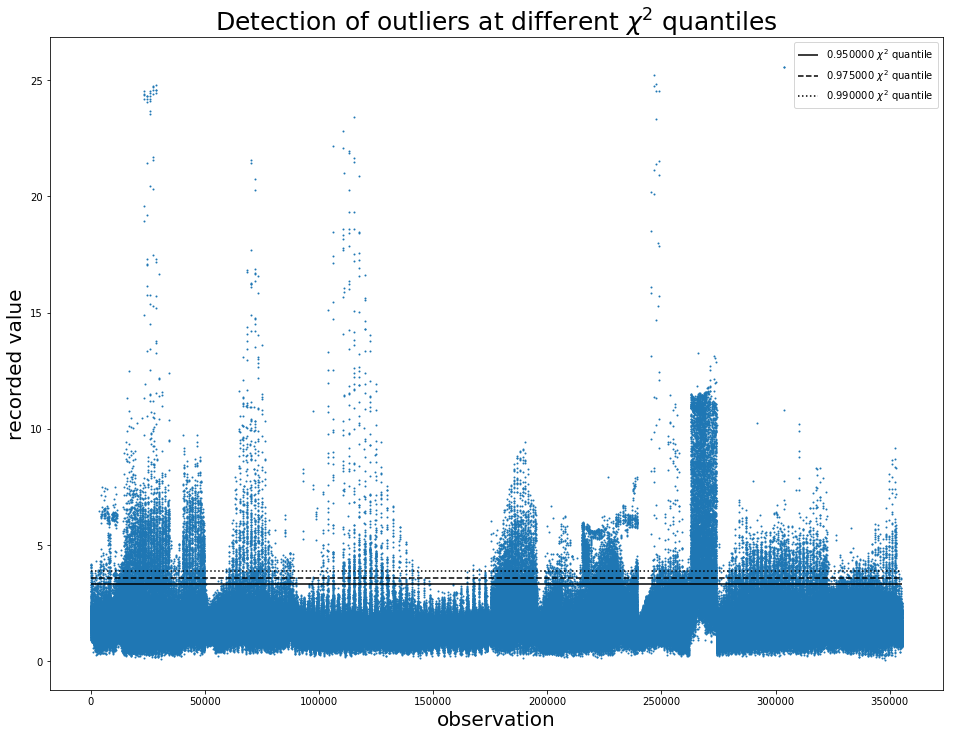

In [16]:
plot_outliers(maha_dis,0.95,0.975,0.99)

In [17]:
# plot the dropped outliers on the original image
dataset =loadmat ("C:\\Users\\hasee\\workspace\\lab\patRecDat\\forStudents\\medData\\dataset.mat",mat_dtype=True)
data = dataset ["dataset"]
cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list('my_cmap',['black','green','blue'],256)
def check_resultofdropping (data,stuck,index,slices,features,selected,dropped):
    
    #plot the original prostate area and the cancer area
    target_data=data[stuck][0][0][0][0][:,:,slices,features]
    target_image1=target_data.reshape(target_data.shape[0],target_data.shape[1])
    target_label=data[stuck][0][0][0][index][:,:,slices]
    target_image2=target_label.reshape(target_label.shape[0],target_label.shape[1])
    plt.imshow(target_image1,cmap = matplotlib.cm.binary,alpha=0.4)
    plt.imshow(target_image2,cmap = cmap1,interpolation="bilinear",alpha=0.4)
    plt.axis("off") #close the axis number
    
    #plot the selected samples
    selected_x=[]
    selected_y=[]
    selected_matrix = selected[selected['stuck_num']==stuck]
    selected_matrix=pd.DataFrame.reset_index(selected_matrix).drop('index',axis=1)
    for i in range(len(selected_matrix)):
        #using Regular expression operations to find the point
        temparr = re.findall("\d+",selected_matrix.iloc[i]['pixel_index'])
        if (int(temparr[2]) == slices):
            selected_x.append(int(temparr[0]))
            selected_y.append(int(temparr[1]))
    plt.scatter(selected_y,selected_x,label="selected samples",s = 3)
    
    #plot the droped samples
    dropped_x=[]
    dropped_y=[]
    dropped_matrix = dropped[dropped['stuck_num']==stuck]
    dropped_matrix = pd.DataFrame.reset_index(dropped_matrix).drop('index',axis=1)
    for i in range(len(dropped_matrix)):
        temparr = re.findall("\d+",dropped_matrix.iloc[i]['pixel_index'])
        if (int(temparr[2]) == slices):
            dropped_x.append(int(temparr[0]))
            dropped_y.append(int(temparr[1]))
    plt.scatter(dropped_y,dropped_x, label="dropped samples", s = 2)
    plt.legend()
    plt.show()


 the blue points are those we keep， and the orange points are those we drop.

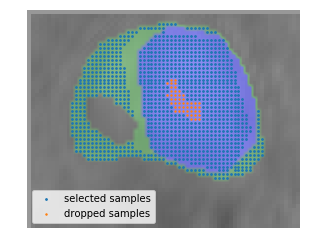

In [18]:
stuck,slices,index,features=7,27,1,0
check_resultofdropping(data,stuck,index,slices,features,y_train_direct,y_directlydropped)

because the number of the subsample set $m$ satisfy $$1-(1-(1-0.5)^{p+1})^m\geq p_{distribution}$$ but this is a large number of groups and it will take a long time to calculate. Due to the paper we know the statistic order of the subset distance $m^2_{k+1}$ satisfly $$m^2_{k+1}\leq(\frac{V_k}{det(C_{k+1})})^{1/p}=M$$ so if $m^2_{k+1}$ exceed, then stop

In [19]:
#resampling algorithm
p_distr=0.975
n_subsamples=np.ceil(log((1-p_distr),1-(0.5)**6)).astype(int)
n_subsamples

235

In [20]:
# robust distance
class outliers_clean_resampling(BaseEstimator,TransformerMixin):
    def __init__(self,p_free,labels,y_dropped=pd.Series([]),md_dis=pd.Series([]),p_value_1=0.,p_value_2=0.,h_value=0):
        self.md_dis=md_dis
        self.p_value_1=p_value_1
        self.p_value_2=p_value_2
        self.p_free=p_free
        self.h_value=h_value
        self.labels=labels
        self.y_dropped=labels
    def fit(self,X,y=None):
        self.h_value=np.int((X.shape[0]+self.p_free+1)/2)
        mean_value=np.array([X.mean()])
        cov_value=np.mat(X.cov().as_matrix()).I
        print("MD Start")
        self.md_dis=distance.cdist(X,mean_value,metric='mahalanobis',VI=cov_value).ravel()
        print("MD end")
        chi2.fit(self.md_dis,self.p_free)
        self.p_value_1=np.sqrt(chi2.ppf(0.99999999,self.p_free))
        self.p_value_2=np.sqrt(chi2.ppf(0.5,self.p_free))
        return self
    def transform(self,X,y=None):
        np.random.seed(30)
        mean_set,cov_set,m_dis_order,V_j=[],[],[],[]
        print("Resampling begin")
        start1=time.time()
        for subset in range(n_subsamples):
            if subset%200==0:
                print("replications number:%d time:%5.1f minute"%(subset,(time.time()-start1)/60))
            sample_ID=[]
            for index in range(self.p_free+1):
                sample_ID.append(np.random.choice(range(len(X)),replace=False))
            X_tr=np.array(X.iloc[sample_ID])
            sub_mean=np.array([(1/(self.p_free+1))*np.sum(X_tr,axis=0)])
            mean_set.append(sub_mean)
            sub_cov=np.mat((1/(self.p_free))*np.dot((X_tr-sub_mean).T,(X_tr-sub_mean))).I
            cov_set.append(sub_cov) 
            m_dis=pd.Series((distance.cdist(X,sub_mean,metric='mahalanobis',VI=sub_cov)**2).ravel())\
            .sort_values(ascending=True).iloc[self.h_value] #ascending=True : from small to big
            #if subset != 0 :
                #if m_dis>=(V_j[subset-1]/sub_cov.I.det())**(1/self.p_free):
                    #break
                #else:
                    #pass
            m_dis_order.append(m_dis)
            V_j.append(m_dis*np.linalg.det(sub_cov))
        print("Resampling end")
        #print(m_dis_order[])
        J_index=pd.Series(V_j).sort_values(ascending=True).index.tolist()[0]
        m_dis_value=m_dis_order[J_index]
        robust_mean=mean_set[J_index]
        robust_cov=((1+15/(X.shape[0]-self.p_free))**2)*(1/self.p_value_2)*m_dis_value*cov_set[J_index]
        print("RD Start")
        robust_dis=distance.cdist(X,robust_mean,metric='mahalanobis',VI=robust_cov).ravel()
        print("RD end")
        print("Robust distance: ",robust_dis)
        print("Cutoff value: ",self.p_value_1)
        count,count1,count2=0,0,0
        count1=X.shape[0]
        print("Drop Start")
        robust_dis=pd.DataFrame(robust_dis,columns=['robust_dis'])
        X=pd.concat([X,robust_dis],axis=1)
        self.labels=pd.concat([self.labels,robust_dis],axis=1)
        self.y_dropped=pd.concat([self.y_dropped,robust_dis],axis=1)
        X=X[X['robust_dis']<=self.p_value_1].copy()
        self.labels=self.labels[self.labels['robust_dis']<=self.p_value_1].copy()
        self.y_dropped=self.y_dropped[self.y_dropped['robust_dis']>self.p_value_1].copy()
        X=pd.DataFrame.reset_index(X).drop('index',axis=1)
        self.labels=pd.DataFrame.reset_index(self.labels).drop('index',axis=1)
        self.y_dropped=pd.DataFrame.reset_index(self.y_dropped).drop('index',axis=1)
        count2=X.shape[0]
        count=count1-count2
        print("Drop End")
        print("drop count:",count)
        return X,self.labels,self.y_dropped,robust_dis

In [21]:
n_subsamples=253
X_train_new,y_train_resample,y_dropped_resample,robust_dis=outliers_clean_resampling(p_free=5,labels=y_train).fit_transform(X_train_scaled)

MD Start
MD end
Resampling begin
replications number:0 time:  0.0 minute
replications number:200 time:  2.4 minute
Resampling end
RD Start
RD end
Robust distance:  [ 4.30574976  3.85514165  4.03134111 ...,  2.47902027  3.67414771
  1.69394282]
Cutoff value:  6.76716980076
Drop Start
Drop End
drop count: 31936


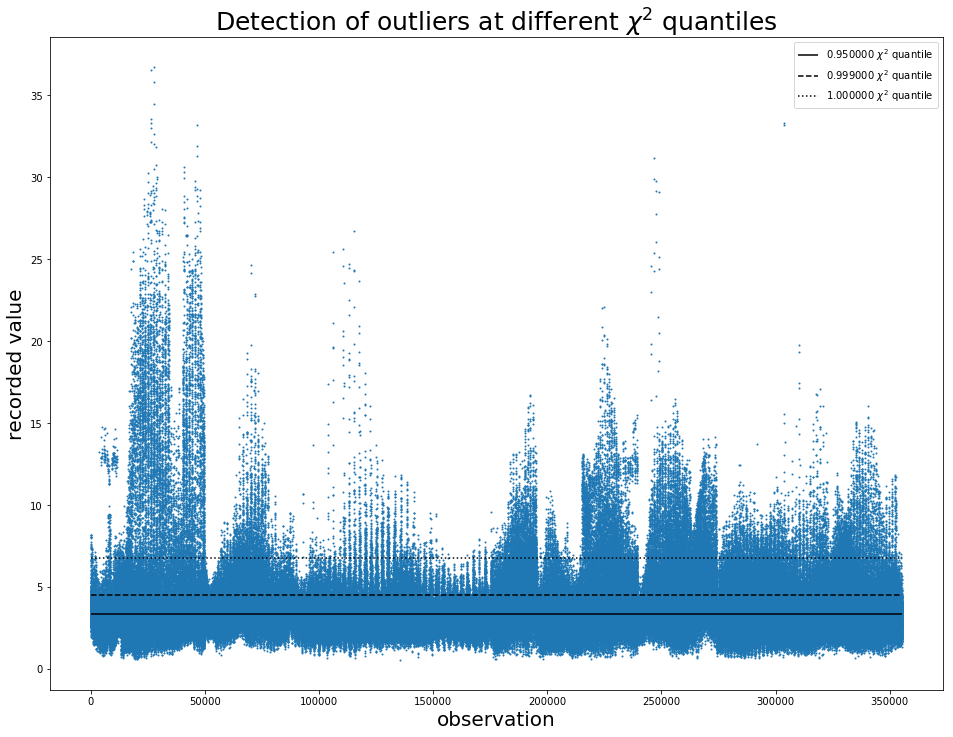

In [22]:
#n_subsample=235
plot_outliers(robust_dis,0.95,0.999,0.99999999)

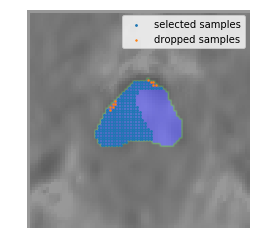

In [23]:
stuck,slices,index,features=1,25,1,0
check_resultofdropping(data,stuck,index,slices,features,y_train_resample,y_dropped_resample)

In [24]:
n_subsamples=3000
X_train_new,y_train_new,y_dropped_new,robust_dis=outliers_clean_resampling(p_free=5,labels=y_train).fit_transform(X_train_scaled)

MD Start
MD end
Resampling begin
replications number:0 time:  0.0 minute
replications number:200 time:  2.5 minute
replications number:400 time:  4.8 minute
replications number:600 time:  7.2 minute
replications number:800 time:  9.5 minute
replications number:1000 time: 11.9 minute
replications number:1200 time: 14.2 minute
replications number:1400 time: 16.6 minute
replications number:1600 time: 19.0 minute
replications number:1800 time: 21.4 minute
replications number:2000 time: 23.7 minute
replications number:2200 time: 26.1 minute
replications number:2400 time: 28.5 minute
replications number:2600 time: 30.8 minute
replications number:2800 time: 33.0 minute
Resampling end
RD Start
RD end
Robust distance:  [ 4.26357033  3.76741953  3.98327861 ...,  5.39999458  4.38063034
  2.34916689]
Cutoff value:  6.76716980076
Drop Start
Drop End
drop count: 43542


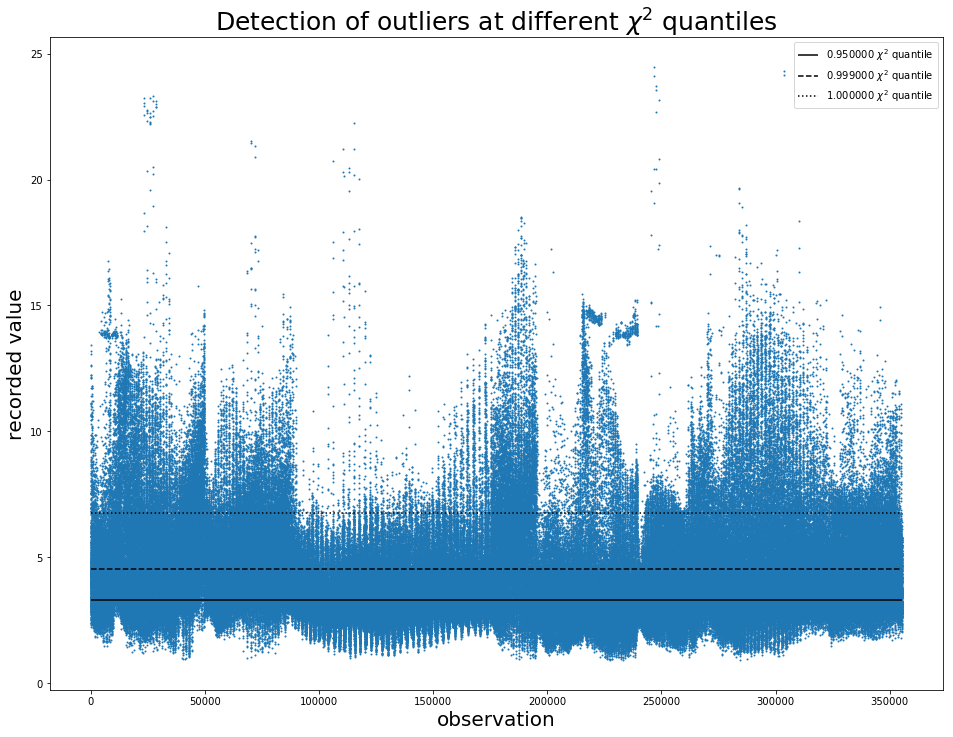

In [25]:
#n_subsample=3000
plot_outliers(robust_dis,0.95,0.999,0.99999999)

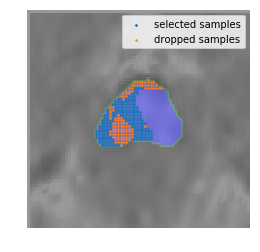

In [26]:
stuck,slices,index,features=1,25,1,0
check_resultofdropping(data,stuck,index,slices,features,y_train_new,y_dropped_new)

In [27]:
#save the result
#use the result of 3000 groups
#X_train_new.to_csv("D:\\lab; signal processing\\forStudents\\medData\\train_resampling3000_X.csv",index=False)
#y_train_new.to_csv("D:\\lab; signal processing\\forStudents\\medData\\train_resampling3000_y.csv",index=False)
X_train_new.to_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\train_resampling3000_X.csv",index=False)
y_train_new.to_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\train_resampling3000_y.csv",index=False)

**Tuning conclusion** :from the plot 1 and plot 2 we can figure out n_subsample or replications better remain low value

## 3.3 Boundray selection

In [28]:
#import clean outliers data
X_train=pd.read_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\train_resampling3000_X.csv")
y_train=pd.read_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\train_resampling3000_y.csv")

In [29]:
X_train=X_train.drop(['robust_dis'],axis=1)
y_train=y_train.drop(['robust_dis'],axis=1)
y_train=y_train.rename(columns={'0':'label'})

first to apply kmeans algorithm to divide dataset into clusters

In [30]:
#boundary detection
class boundary_detection(BaseEstimator,TransformerMixin):
    def __init__(self,labels,kmeans):
        self.labels=labels
        self.kmeans=kmeans
    def fit(self,X,y=None):
        start=time.time()
        print("fit start")
        self.kmeans.fit(X)
        print("fit end")
        print("fit time:%5.1fminute"%((time.time()-start)/60))
        return self
    def transform(self,X,y=None):
        #dataset=pd.concat([X,self.labels],axis=1)
        count1=X.shape[0]
        predict_cluster = self.kmeans.predict(X)
        predict_cluster=pd.DataFrame( predict_cluster,columns=['predict_cluster'])
        X=pd.concat([X,predict_cluster],axis=1)
        self.labels=pd.concat([self.labels,predict_cluster],axis=1)
        #center_set = pd.DataFrame(columns = ['feature0','feature1','feature2','feature3','feature4','predict_label'])
        center_set = list()
        i = 0
        #print (X)
        #print (self.kmeans.cluster_centers_)
        print("drop start")
        for cluster in range(np.int((X.shape[0])/50)):
            if cluster%1000==0:
                print("cluster number:",cluster)
            temp_list = list(self.labels[self.labels['predict_cluster']==cluster]['label'])
            if 1 and 2 in temp_list:
                pass
            elif temp_list == []:  
                pass
            else:
                #temp =temp_list[0]
                #temp_center = np.append(self.kmeans.cluster_centers_[cluster],temp)
                temp_center_set = {'feature0':self.kmeans.cluster_centers_[cluster][0],\
                                  'feature1':self.kmeans.cluster_centers_[cluster][1],\
                                  'feature2':self.kmeans.cluster_centers_[cluster][2],\
                                  'feature3':self.kmeans.cluster_centers_[cluster][3],\
                                  'feature4':self.kmeans.cluster_centers_[cluster][4],\
                                  'predict_label':temp_list[0]}
                #temp = pd.DataFrame(data=temp_center_set,index = cluster)
                #center_set = pd.concat(center_set,temp_center_set)
                center_set.append(temp_center_set)
                self.labels = self.labels[self.labels.predict_cluster !=cluster]
                X = X[X.predict_cluster != cluster]
        #dataset.append(pd.DataFrame(self.kmeans.cluster_centers_))#save all the centers of abandoned clusters
        print("drop end")
        count2=X.shape[0]
        print("Drop count:",count1-count2)        
        return X,self.labels,center_set

In [32]:
#apply the function with 30 samples in one cluster
X_boundary,y_boundary,center=boundary_detection(labels=y_train,kmeans=MiniBatchKMeans(n_clusters=np.int((X_train.shape[0])/50),\
                                                                  n_init=1,max_iter=100,\
                                                                  init_size=3*np.int((X_train.shape[0])/50),verbose=-1,\
                                                                  random_state=42)).fit_transform(X_train)

fit start
Init 1/1 with method: k-means++
Inertia for init 1/1: 610.376673
Minibatch iteration 1/312000: mean batch inertia: 0.070832, ewa inertia: 0.070832 
Minibatch iteration 2/312000: mean batch inertia: 0.054560, ewa inertia: 0.070822 
Minibatch iteration 3/312000: mean batch inertia: 0.057996, ewa inertia: 0.070814 
Minibatch iteration 4/312000: mean batch inertia: 0.064985, ewa inertia: 0.070810 
Minibatch iteration 5/312000: mean batch inertia: 0.052180, ewa inertia: 0.070798 
Minibatch iteration 6/312000: mean batch inertia: 0.056987, ewa inertia: 0.070789 
Minibatch iteration 7/312000: mean batch inertia: 0.054877, ewa inertia: 0.070779 
Minibatch iteration 8/312000: mean batch inertia: 0.055594, ewa inertia: 0.070769 
Minibatch iteration 9/312000: mean batch inertia: 0.057051, ewa inertia: 0.070760 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 10/312000: mean batch inertia: 0.063862, ewa inertia: 0.070756 
Minibatch iteration 11/312000: mean batch in

Minibatch iteration 96/312000: mean batch inertia: 0.052523, ewa inertia: 0.070038 
Minibatch iteration 97/312000: mean batch inertia: 0.062492, ewa inertia: 0.070033 
Minibatch iteration 98/312000: mean batch inertia: 0.063872, ewa inertia: 0.070029 
Minibatch iteration 99/312000: mean batch inertia: 0.045037, ewa inertia: 0.070013 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 100/312000: mean batch inertia: 0.066860, ewa inertia: 0.070011 
Minibatch iteration 101/312000: mean batch inertia: 0.075920, ewa inertia: 0.070015 
Minibatch iteration 102/312000: mean batch inertia: 0.047990, ewa inertia: 0.070001 
Minibatch iteration 103/312000: mean batch inertia: 0.098325, ewa inertia: 0.070019 
Minibatch iteration 104/312000: mean batch inertia: 0.052969, ewa inertia: 0.070008 
Minibatch iteration 105/312000: mean batch inertia: 0.051656, ewa inertia: 0.069996 
Minibatch iteration 106/312000: mean batch inertia: 0.062166, ewa inertia: 0.069991 
Minibatch iteration

Minibatch iteration 191/312000: mean batch inertia: 0.056073, ewa inertia: 0.069419 
Minibatch iteration 192/312000: mean batch inertia: 0.056965, ewa inertia: 0.069411 
Minibatch iteration 193/312000: mean batch inertia: 0.069819, ewa inertia: 0.069411 
Minibatch iteration 194/312000: mean batch inertia: 0.054294, ewa inertia: 0.069402 
Minibatch iteration 195/312000: mean batch inertia: 0.056016, ewa inertia: 0.069393 
Minibatch iteration 196/312000: mean batch inertia: 0.072090, ewa inertia: 0.069395 
Minibatch iteration 197/312000: mean batch inertia: 0.060754, ewa inertia: 0.069389 
Minibatch iteration 198/312000: mean batch inertia: 0.070907, ewa inertia: 0.069390 
Minibatch iteration 199/312000: mean batch inertia: 0.061569, ewa inertia: 0.069385 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 200/312000: mean batch inertia: 0.090765, ewa inertia: 0.069399 
Minibatch iteration 201/312000: mean batch inertia: 0.073566, ewa inertia: 0.069402 
Minibatch itera

In [33]:
len(y_boundary[y_boundary['label']==1])

198544

In [34]:
len(y_boundary[y_boundary['label']==2])

49203

In [35]:
center_set = pd.DataFrame(data = center)

In [40]:
cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list('my_cmap',['black','green','blue'],256)
def check_resultofdropping (data,stuck,index,slices,features,selected):
    target_data=data[stuck][0][0][0][0][:,:,slices,features]
    target_image1=target_data.reshape(target_data.shape[0],target_data.shape[1])
    target_label=data[stuck][0][0][0][index][:,:,slices]
    target_image2=target_label.reshape(target_label.shape[0],target_label.shape[1])
    plt.imshow(target_image1,cmap = matplotlib.cm.binary,alpha=0.4)
    plt.imshow(target_image2,cmap = cmap1,interpolation="bilinear",alpha=0.4)
    plt.axis("off") #close the axis number

    selected_x=[]
    selected_y=[]
    selected_matrix = selected[selected['stuck_num']==stuck]
    selected_matrix=pd.DataFrame.reset_index(selected_matrix).drop('index',axis=1)
    for i in range(len(selected_matrix)):
        temparr = re.findall("\d+",selected_matrix.iloc[i]['pixel_index']) 
        if (int(temparr[2]) == slices):
            selected_x.append(int(temparr[0]))
            selected_y.append(int(temparr[1]))
    plt.scatter(selected_y,selected_x,color='r',label="selected boundary",s = 3)
    plt.legend()
    plt.show()


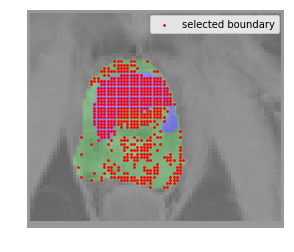

In [41]:
stuck,slices,index,features=4,24,1,4
check_resultofdropping(data,stuck,index,slices,features,y_boundary)

In [42]:
#save the result
X_boundary.to_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\train_x_resample3000_boundarysel_50pergroup.csv",index=False)
y_boundary.to_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\train_y_resample3000_boundarysel_50pergroup.csv",index=False)
#X_boundary.to_csv("D:\\lab; signal processing\\forStudents\\medData\\train_x_resample3000_boundarysel_50pergroup.csv",index=False)
#y_boundary.to_csv("D:\\lab; signal processing\\forStudents\\medData\\train_y_resample3000_boundarysel_50pergroup.csv",index=False)

# 4. Build the model

In the model construction part ,**our plan ** is that:
- train servarl models
- calculate the f1-scores,accuracy,roc_curve
- choose the best model
- tuning the parameters of the model

In [4]:
X_train=pd.read_csv("D:\\lab; signal processing\\forStudents\\medData\\train_x_boundarysel_50pergroup.csv")
y_train=pd.read_csv("D:\\lab; signal processing\\forStudents\\medData\\train_y_boundarysel_50pergroup.csv")
X_val=pd.read_csv("D:\\lab; signal processing\\forStudents\\medData\\scaled_validation_feature.csv")
y_val=pd.read_csv("D:\\lab; signal processing\\forStudents\\medData\\validation_label.csv")
#X_train=train_set.drop(["label"],axis=1)
#y_train=train_set["label"]

In [5]:
X_train = X_train.drop(["predict_cluster"],axis=1)
y_train = y_train.drop(["predict_cluster"],axis=1)
X_val = X_val.drop(["Unnamed: 0"],axis=1)
y_val = y_val.drop(["Unnamed: 0"],axis=1)

In [6]:
#X_val = X_val.drop(["sourceofpixel"],axis=1)
y_val = y_val.drop(["sourceofpixel"],axis=1)
y_train = y_train.drop(["sourceofpixel"],axis=1)

In [7]:
y_val = y_val.drop(["indexofpixel"],axis=1)
y_train = y_train.drop(["indexofpixel"],axis=1)

In [8]:
def cal_score (y_pred,y_val):
    n11 = 0
    n12 = 0
    n21 = 0
    n22 = 0
    y_pred_array= np.array(y_pred)
    y_val_array= np.array(y_val)
    ita = np.nditer (y_pred_array)
    itb = np.nditer (y_val_array)
    while not ita.finished:
        if (ita[0]==2)&(itb[0]==2):
            n22 = n22+1
        elif (ita[0]==1)&(itb[0]==2):
            n12 = n12+1
        elif (ita[0]==2)&(itb[0]==1):
            n21 = n21+1
        else:
            n11 = n11+1
        ita.iternext()
        itb.iternext()
        
    Precall = n22 / ( n12 + n22)
    Pprecision = n22 / ( n21 + n22)
    f1_score = 2 / (1/Precall + 1/Pprecision)
    print ("n11:.."+str(n11)+"..n12:.."+str(n12)+"..n21:.."+str(n21)+"..n22:.."+str(n22))
    print ("TP:"+str(Precall))
    print ("f1 score:" + str(f1_score))
    FP = n21/(n21 + n11)
    FN = n12/(n12 +n22 )
    BER = 1/2*(FP+FN)
    print ("FP:"+ str(FP))
    print ("BER:" + str(BER))
    return Precall,f1_score,BER

In [9]:
#Nearest Mean algorithm
def nn_predict(X_val,X_train,y_train):
    y_pred=[]
    y_proba_1=[]
    y_proba_2=[]
    class_1=X_train[y_train['label']==1]
    class_2=X_train[y_train['label']==2]
    print(class_1.shape)
    mean_1=np.array(class_1.mean()).reshape(1,-1)
    mean_2=np.array(class_2.mean()).reshape(1,-1)
    print(mean_2.shape)
    cov_1=np.matrix(class_1.cov())
    cov_2=np.matrix(class_2.cov())
    print("NN start")
    start=time.time()
    dis_1=distance.cdist(X_val,mean_1,metric='mahalanobis',V=cov_1).ravel()
    dis_2=distance.cdist(X_val,mean_2,metric='mahalanobis',V=cov_2).ravel()
# get the k nearest mahalanobis distance
    for index in range(len(X_val)):
        #if index%1000==0:
        #    print("the index is %d and time is %5.1f second"%(index,(time.time()-start)))
        if dis_1[index]<dis_2[index]:
                y_pred.append(np.float64(1.0)) #added the weight to the vote
        else:
                y_pred.append(np.float64(2.0))
        y_proba_1.append(dis_2[index]/(dis_1[index]+dis_2[index]))
        y_proba_2.append(dis_1[index]/(dis_1[index]+dis_2[index]))
    print("NN STOP")
    y_pred=pd.Series(y_pred)
    return y_pred,y_proba_1,y_proba_2
    
        

In [10]:
y_pred,y_proba_1,y_proba_2=nn_predict(X_val,X_train,y_train)

(216609, 5)
(1, 5)
NN start
NN STOP


In [11]:
y_pred = {"label_pred":y_pred}
y_pred = pd.DataFrame(data=y_pred)

In [12]:
y_pred,y_proba_1,y_proba_2=nn_predict(X_val,X_train,y_train)

n11:..52414..n12:..2714..n21:..8793..n22:..6106
TP:0.6922902494331066
f1 score:0.5148615034360638
FP:0.14366003888444132
BER:0.22568489472566738


In [13]:
y_pred_train,y_proba_1_train,y_proba_2_train=nn_predict(X_train,X_train,y_train)

(216609, 5)
(1, 5)
NN start
NN STOP


In [14]:
y_pred_train = {"label_pred":y_pred_train}
y_pred_train = pd.DataFrame(data=y_pred_train)

In [15]:
Precall,f1_score,BER = cal_score (y_pred_train,y_train) 

n11:..183086..n12:..14360..n21:..33523..n22:..34843
TP:0.7081478771619617
f1 score:0.5927242725548401
FP:0.1547627291571449
BER:0.22330742599759162


we use the f1 score to analysis our model, $$P_{f1}=2*\frac{1}{\frac{1}{P_{recall}}+\frac{1}{P_{precision}}}$$

In [171]:
#f1_score(y_val,y_pred)

0.90872650085835815

In [175]:
from sklearn.neighbors.nearest_centroid import NearestCentroid
clf = NearestCentroid()
clf.fit(X_train,y_train)
NearestCentroid(metric='mahalanobis',shrink_threshold=None)

C:\Users\yangshanqi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



NearestCentroid(metric='mahalanobis', shrink_threshold=None)

In [176]:
y_pred_nnpackage = clf.predict(X_val)

In [177]:
y_pred_nnpackage = {"label":y_pred_nnpackage }
y_pred_nnpackage  = pd.DataFrame(data=y_pred_nnpackage )

In [178]:
Precall,f1_score,BER = cal_score (y_pred_nnpackage,y_val) 

n11:..48713..n12:..1588..n21:..12494..n22:..7232
TP:0.8199546485260771
f1 score:0.5066909549499055
BER:1.3014992502475822


In [75]:
balanced_error_rate(y_val,y_pred_nnpackage)

0.2816913476230597
0.7183086523769403


0.5

In [16]:
clf1 = neighbors.KNeighborsClassifier()
clf1.fit(X_train,y_train)

C:\Users\yangshanqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [17]:
y_pred_knnpackage = clf1.predict(X_val)

In [18]:
y_pred_knnpackage = {"label":y_pred_knnpackage }
y_pred_knnpackage  = pd.DataFrame(data=y_pred_knnpackage )

In [20]:
TPR_knn,f1_score_knn,BER_knn = cal_score(y_val,y_pred_knnpackage)


n11:..55663..n12:..5544..n21:..5333..n22:..3487
TP:0.3861144945188794
f1 score:0.39067839336731836
FP:0.08743196275165585
BER:0.3506587341163882


In [16]:
#accuracy_score(y_val,y_pred) #validation accuracy

0.92834030008866775

In [22]:
#calculate tp amd fp
fp_nn,tp_nn,thresholds_nn=roc_curve(y_val,y_proba_2,pos_label=2)

In [3]:
#function plot the ROC
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


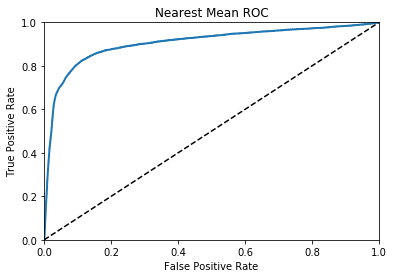

In [24]:
plt.title("Nearest Mean ROC")
plot_roc_curve(fp_nn,tp_nn,label='Nearest Mean')
plt.show()

In [116]:
def knn_predict(X_val,X_train,y_train,k_value):
    y_pred=[]
    y_proba_1=[]
    y_proba_2=[]
    cov_train=np.matrix(X_train.cov())
    print("KNN start")
    start=time.time()
    for test_index in range(len(X_val)):
        if test_index%100==0:
            print("the X_val is %d and time is %5.1f minute"%(test_index,(time.time()-start)/60))
        good=0
        bad=0
        sample=np.array(X_val.iloc[test_index]).reshape(1,-1)
        m_dis=pd.Series((distance.cdist(X_train,sample,metric='mahalanobis',V=cov_train)).ravel())\
        .sort_values(ascending=True)#average computing time 0.12s
        dis_set=m_dis[:k_value]# get the k nearest mahalanobis distance
        for index in dis_set.index:
            if y_train.loc[index] == 1.0:
                good += 1/dis_set.loc[index] #added the weight to the vote
            else:
                bad += 1/dis_set.loc[index]
        if good > bad :
            y_pred.append(np.float64(1.0))
        else:
            y_pred.append(np.float64(2.0))
        y_proba_1.append(good/(good+bad))
        y_proba_2.append(bad/(good+bad))
    print("KNN STOP")
    y_pred=pd.Series(y_pred)
    return y_pred,y_proba_1,y_proba_2

In [44]:
y_pred_t,y_proba_1_t,y_proba_2_t=knn_predict(X_val,X_train,y_train,5,cov_train)

KNN start
the X_val is 0 and time is   0.0 minute
0.13538527488708496
0.14099836349487305
0.12328314781188965
0.12736105918884277
0.12127208709716797
0.13768291473388672
0.12312197685241699
0.12457013130187988
0.11896967887878418
0.12837600708007812
0.12888503074645996
0.13399076461791992
0.1268908977508545
0.13985300064086914
0.12532353401184082
0.12438178062438965
0.12375378608703613
0.1298820972442627
0.12486624717712402
0.12816977500915527
0.13303470611572266
0.12490034103393555
0.12238955497741699
0.1285414695739746
0.11782240867614746
0.13056445121765137
0.11941075325012207
0.1259748935699463
0.12488412857055664
0.12718796730041504
0.13195252418518066
0.1439225673675537
0.13043618202209473
0.12739062309265137
0.12279605865478516
0.12287306785583496
0.12891316413879395
0.12630581855773926
0.13139748573303223
0.13092780113220215
0.1243600845336914
0.12434911727905273
0.12583589553833008
0.12835121154785156
0.12785911560058594
0.1268458366394043
0.1298539638519287
0.128889799118042


KeyboardInterrupt: 

In [8]:
y_pred_knn,y_proba_1_knn,y_proba_2_knn=knn_predict(X_val,X_train,y_train,5,cov_train)

KNN start
the X_val is 0 and time is   0.0 minute
the X_val is 100 and time is   0.2 minute
the X_val is 200 and time is   0.5 minute
the X_val is 300 and time is   0.7 minute
the X_val is 400 and time is   0.9 minute
the X_val is 500 and time is   1.1 minute
the X_val is 600 and time is   1.3 minute
the X_val is 700 and time is   1.5 minute
the X_val is 800 and time is   1.7 minute
the X_val is 900 and time is   1.9 minute
the X_val is 1000 and time is   2.1 minute
the X_val is 1100 and time is   2.3 minute
the X_val is 1200 and time is   2.5 minute
the X_val is 1300 and time is   2.7 minute
the X_val is 1400 and time is   2.9 minute
the X_val is 1500 and time is   3.1 minute
the X_val is 1600 and time is   3.3 minute
the X_val is 1700 and time is   3.6 minute
the X_val is 1800 and time is   3.8 minute
the X_val is 1900 and time is   4.0 minute
the X_val is 2000 and time is   4.2 minute
the X_val is 2100 and time is   4.4 minute
the X_val is 2200 and time is   4.6 minute
the X_val is 

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning:

divide by zero encountered in double_scalars

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



the X_val is 18800 and time is  38.9 minute
the X_val is 18900 and time is  39.1 minute
the X_val is 19000 and time is  39.3 minute
the X_val is 19100 and time is  39.5 minute
the X_val is 19200 and time is  39.7 minute
the X_val is 19300 and time is  39.9 minute
the X_val is 19400 and time is  40.2 minute
the X_val is 19500 and time is  40.4 minute
the X_val is 19600 and time is  40.6 minute
the X_val is 19700 and time is  40.8 minute
the X_val is 19800 and time is  41.0 minute
the X_val is 19900 and time is  41.2 minute
the X_val is 20000 and time is  41.4 minute
the X_val is 20100 and time is  41.6 minute
the X_val is 20200 and time is  41.8 minute
the X_val is 20300 and time is  42.0 minute
the X_val is 20400 and time is  42.2 minute
the X_val is 20500 and time is  42.4 minute
the X_val is 20600 and time is  42.6 minute
the X_val is 20700 and time is  42.9 minute
the X_val is 20800 and time is  43.1 minute
the X_val is 20900 and time is  43.3 minute
the X_val is 21000 and time is  

the X_val is 37500 and time is  77.6 minute
the X_val is 37600 and time is  77.9 minute
the X_val is 37700 and time is  78.1 minute
the X_val is 37800 and time is  78.3 minute
the X_val is 37900 and time is  78.5 minute
the X_val is 38000 and time is  78.7 minute
the X_val is 38100 and time is  78.9 minute
the X_val is 38200 and time is  79.1 minute
the X_val is 38300 and time is  79.3 minute
the X_val is 38400 and time is  79.5 minute
the X_val is 38500 and time is  79.7 minute
the X_val is 38600 and time is  79.9 minute
the X_val is 38700 and time is  80.1 minute
the X_val is 38800 and time is  80.3 minute
the X_val is 38900 and time is  80.6 minute
the X_val is 39000 and time is  80.8 minute
the X_val is 39100 and time is  81.0 minute
the X_val is 39200 and time is  81.2 minute
the X_val is 39300 and time is  81.4 minute
the X_val is 39400 and time is  81.6 minute
the X_val is 39500 and time is  81.8 minute
the X_val is 39600 and time is  82.0 minute
the X_val is 39700 and time is  

the X_val is 56200 and time is 116.4 minute
the X_val is 56300 and time is 116.6 minute
the X_val is 56400 and time is 116.8 minute
the X_val is 56500 and time is 117.0 minute
the X_val is 56600 and time is 117.2 minute
the X_val is 56700 and time is 117.4 minute
the X_val is 56800 and time is 117.6 minute
the X_val is 56900 and time is 117.8 minute
the X_val is 57000 and time is 118.0 minute
the X_val is 57100 and time is 118.3 minute
the X_val is 57200 and time is 118.5 minute
the X_val is 57300 and time is 118.7 minute
the X_val is 57400 and time is 118.9 minute
the X_val is 57500 and time is 119.1 minute
the X_val is 57600 and time is 119.3 minute
the X_val is 57700 and time is 119.5 minute
the X_val is 57800 and time is 119.7 minute
the X_val is 57900 and time is 119.9 minute
the X_val is 58000 and time is 120.1 minute
the X_val is 58100 and time is 120.3 minute
the X_val is 58200 and time is 120.5 minute
the X_val is 58300 and time is 120.7 minute
the X_val is 58400 and time is 1

the X_val is 74900 and time is 155.6 minute
the X_val is 75000 and time is 155.8 minute
the X_val is 75100 and time is 156.1 minute
the X_val is 75200 and time is 156.3 minute
the X_val is 75300 and time is 156.5 minute
the X_val is 75400 and time is 156.8 minute
the X_val is 75500 and time is 157.0 minute
the X_val is 75600 and time is 157.2 minute
the X_val is 75700 and time is 157.5 minute
the X_val is 75800 and time is 157.7 minute
the X_val is 75900 and time is 158.0 minute
the X_val is 76000 and time is 158.2 minute
the X_val is 76100 and time is 158.5 minute
the X_val is 76200 and time is 158.7 minute
the X_val is 76300 and time is 159.0 minute
the X_val is 76400 and time is 159.2 minute
the X_val is 76500 and time is 159.5 minute
the X_val is 76600 and time is 159.7 minute
the X_val is 76700 and time is 159.9 minute
the X_val is 76800 and time is 160.1 minute
the X_val is 76900 and time is 160.4 minute
the X_val is 77000 and time is 160.6 minute
the X_val is 77100 and time is 1

In [10]:
y_pred_knn=pd.Series(y_pred_knn)

In [12]:
#output the prediction and probability 
y_pred_knn.to_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\y_pred_knn.csv",index=False)
pd.Series(y_proba_1_knn).to_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\y_proba_1_knn.csv",index=False)
pd.Series(y_proba_2_knn).to_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\y_proba_2_knn.csv",index=False)

In [4]:
y_pred_knn=pd.read_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\y_pred_knn.csv")
y_proba_1_knn=pd.read_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\y_proba_1_knn.csv")
y_proba_2_knn=pd.read_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\y_proba_2_knn.csv")

In [6]:
f1_score(y_val,y_pred_knn)

ValueError: Found input variables with inconsistent numbers of samples: [86841, 86840]

In [5]:
accuracy_score(y_val,y_pred_knn)

ValueError: Found input variables with inconsistent numbers of samples: [86841, 86840]

In [16]:
fp_knn,tp_knn,thresholds_knn=roc_curve(y_val,y_proba_2_knn,pos_label=2)

then we implement SVM,sing linearSVC which using estimator **liblinear** , will converge quickly in large dataset

In [1]:
rbf_kernel=RBFSampler(gamma=1,n_components=300, random_state=42)#n_components is tradeoff between the running time and accuracy
X_train_nonlinear=rbf_kernel.fit_transform(X_train)

NameError: name 'RBFSampler' is not defined

In [2]:
X_train_nonlinear.shape

NameError: name 'X_train_nonlinear' is not defined

In [ ]:
svm_clf=LinearSVC(C=1,loss="hinge")

In [ ]:
svm_clf.fit(X_train_nonlinear,y_train)

In [ ]:
X_val_nonlinear=rbf_kernel.transform(X_val)

In [ ]:
y_pred_svm=svm_clf.predict(X_val_nonlinear)

In [ ]:
f1_score(y_val,y_pred_svm)

In [ ]:
accuracy_score(y_train,svm_clf.predict(X_train_nonlinear)) #training set accuracy

In [ ]:
accuracy_score(y_val,y_pred_svm) #validation accuracy

In [ ]:
y_score_svm=svm_clf.decision_function(X_val_nonlinear)

In [ ]:
fp_svm,tp_svm,thresholds_svm=roc_curve(y_val,y_score_svm,pos_label=2)

we also try to compare with linearSVC and SVC which use **libsvm** instead

In [21]:
svc_clf=SVC(kernel="rbf",degree=len(X_train),coef0=1,C=1)

In [22]:
svc_clf.fit(X_train,y_train)

C:\Users\yangshanqi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



SVC(C=1, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=265812, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [23]:
y_pred_svc=svc_clf.predict(X_val)

In [24]:
TPR_svc, f1_score_svc, BER_svc = cal_score(y_pred_svc,y_val)

n11:..57892..n12:..5870..n21:..3315..n22:..2950
TP:0.3344671201814059
f1 score:0.39111700364600593
FP:0.054160471841456045
BER:0.35984667583002505


In [30]:
y_score_svc=svc_clf.decision_function(X_val)

In [31]:
fp_svc,tp_svc,thresholds_svc=roc_curve(y_val,y_score_svc,pos_label=2)

In [32]:
f1_score(y_val,y_pred_svc)

0.97359425315828585

In [33]:
accuracy_score(y_val,y_pred_svc)

0.95089876901463599

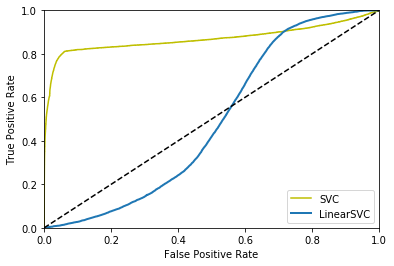

In [96]:
plt.plot(fp_svc,tp_svc,"y-",label="SVC")
plot_roc_curve(fp_svm,tp_svm,label='LinearSVC')
plt.legend()
plt.show()

then we try the XGBClassifier, which implement xgboost algorithm , this classifier has good performance in the Kaggle competition

In [123]:
xgb_clf=XGBClassifier(  n_estimators=500,
                        max_depth=4,
                        objective="binary:logistic",
                        learning_rate=0.03, 
                        subsample=.8,
                        min_child_weight=6,
                        colsample_bytree=.8,
                        scale_pos_weight=1.6,
                        gamma=10,
                        reg_alpha=8,
                        reg_lambda=1.3
                     )

In [125]:
xgb_clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=10, learning_rate=0.03, max_delta_step=0, max_depth=4,
       min_child_weight=6, missing=None, n_estimators=500, nthread=-1,
       objective='binary:logistic', reg_alpha=8, reg_lambda=1.3,
       scale_pos_weight=1.6, seed=0, silent=True, subsample=0.8)

In [126]:
y_pred=xgb_clf.predict(X_val)

In [139]:
xgb_clf.feature_importances_

array([ 0.21690141,  0.20018779,  0.22159624,  0.21239437,  0.14892019], dtype=float32)

In [128]:
f1_score(y_val,y_pred)

0.97769589194423667

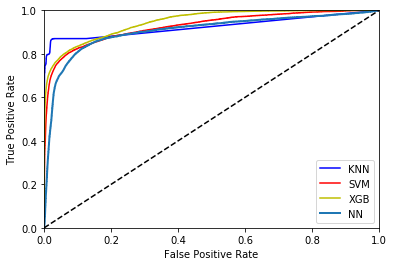

In [130]:
fp_xgb,tp_xgb,thresholds_xgb=roc_curve(y_val,xgb_clf.predict_proba(X_val)[:,1],pos_label=2)
plt.plot(fp_knn,tp_knn,"b-",label="KNN")
plt.plot(fp_svm,tp_svm,"r-",label="SVM")
plt.plot(fp_xgb,tp_xgb,"y-",label="XGB")
plot_roc_curve(fp_nn,tp_nn,label='NN')
plt.legend()
plt.show()

In [140]:
importance_xgb=xgb_clf.feature_importances_
features=["T2 weighted","ADC","Ktrans","Kep","PET"]

In [141]:
#using the attribute of random forest to analysis the importances of features
def plot_feature_imp(importance,features):
    trace2 = go.Bar(
        x=importance,
        y=features,
        marker=dict(
            color=importance,
            colorscale = 'Viridis',
            reversescale = True
        ),
        name='Random Forest Feature importance',
        orientation='h',
    )
    layout = dict(
        title='Barplot of Feature importances',
         width = 700, height = 400,
        yaxis=dict(
            showgrid=False,
            showline=False,
            showticklabels=True,
#             domain=[0, 0.85],
        ))

    fig1 = go.Figure(data=[trace2])
    fig1['layout'].update(layout)
    py.iplot(fig1, filename='plots')

In [142]:
plot_feature_imp(importance_xgb,features)

seems importances is sensitive to classifier(XGB and RDF) better plot 2 classes of samples and seee

Here we try another classifier random forest

In [11]:
#use random forest to make a test
rdf_clf=RandomForestClassifier(random_state=42)
y_proba=cross_val_predict(rdf_clf,X_train,y_train,cv=3,method="predict_proba")

In [12]:
y_score=y_proba[:,1]
fp_rdf,tp_rdf,thresholds_rdf=roc_curve(y_train,y_score,pos_label=2)

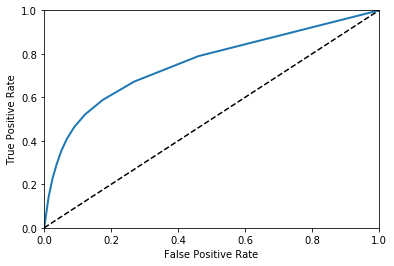

In [33]:
plot_roc_curve(fp_rdf,tp_rdf,label='randomforest')

then we use the attributes of random forest **feature importance** to analysis features

In [13]:
rdf_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [35]:
importance_rdf=rdf_clf.feature_importances_
features=["T2 weighted","ADC","Ktrans","Kep","PET"]

In [37]:
 plot_feature_imp(importance_rdf,features)

# 5.Feature selection

# 6. Prediction & Visualization

## 6.1 plot prediction on the image

first we try to plot the prediction and plot it on the T2 weighted

In [77]:
#plot the test sample(image and label)
def plot_prediction(test_shape,test_sample,new_label,feature): 
    #the feature contains ['0','1','2','3','4'] represent five features respectively
    #change the dataframe to ndarray
    image_size=test_sample[feature].values.reshape(test_shape[0],test_shape[1])
    image_label=new_label.values.reshape(test_shape[0],test_shape[1])
    
    #set up cmap
    cmap1 = matplotlib.colors.LinearSegmentedColormap.\
    from_list('my_cmap',['black','red','blue'],256)
    plt.imshow(image_size,cmap = matplotlib.cm.binary,alpha=0.8)
    plt.imshow(image_label,cmap = cmap1,interpolation="bilinear",alpha=0.2)
    plt.axis("off") #close the axis number
    plt.show()
    

In [135]:

def predict_sample(X,y,MODE,clf=RandomForestClassifier(random_state=42)):
    #predict function for Random forest and SVM
    if MODE == 'SVM' or MODE == 'RF' or MODE == 'XGB':
        label=[]
        for i in range(len(X)):
            if np.int(y.iloc[i]) == 0: #the non-prostate area
                label.append(np.float64(0.0))
            else:
                label.append(np.float64(clf.predict(X.iloc[i:i+1])))#predict on every sample
        label=pd.DataFrame(label,columns=['label'])
    #prediction function for NN
    if MODE == 'NN':
        label,_,_=nn_predict(X,X_train,y_train)
        for i in range(len(X)):
            if np.int(y.iloc[i]) == 0:
                label.iloc[i] = 0.0
            else:
                continue
    #prediction function for KNN
    if MODE == 'KNN':
        label,_,_=knn_predict(X,X_train,y_train,5)
        for i in range(len(X)):
            if np.int(y.iloc[i]) == 0:
                label.iloc[i] = 0.0
            else:
                continue
        #label=pd.DataFrame(label,columns=['label'])
    return label
    
    

In [72]:
#set up a test_sample(one slice feature image)
test_sample=data[1][0][0][0][0][:,:,40,:]
test_sample=pd.DataFrame(test_sample.reshape(test_sample.shape[0]*test_sample.shape[1],5),\
                         columns=["0","1","2","3","4"]) #columns name needs to be changed
#test_sample.isnull()
feature_eng.transform(test_sample)
test_label=data[1][0][0][0][1][:,:,40]
test_shape=test_label.shape
test_label=pd.Series(test_label.ravel())

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.



In [108]:
#predict new label using Nearest mean
MODE='NN'
new_label_nn=predict_sample(test_sample,test_label,MODE=MODE)

KNN start
the index is 0 and time is   0.0 second
the index is 1000 and time is   0.0 second
the index is 2000 and time is   0.0 second
the index is 3000 and time is   0.0 second
the index is 4000 and time is   0.0 second
the index is 5000 and time is   0.0 second
the index is 6000 and time is   0.0 second
KNN STOP


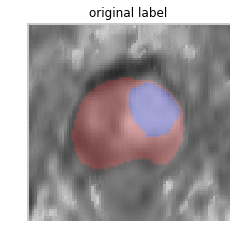

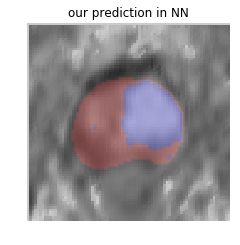

In [110]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title("original label")
plot_prediction(test_shape,test_sample,test_label,'0')
plt.figure(figsize=(8,4))
plt.subplot(122)
plt.title("our prediction in NN")
plot_prediction(test_shape,test_sample,new_label_nn,'0')

In [118]:
#predict the knn
MODE='KNN'
new_label_knn=predict_sample(test_sample,test_label,MODE=MODE)

KNN start
the X_val is 0 and time is   0.0 minute
the X_val is 100 and time is   0.2 minute
the X_val is 200 and time is   0.5 minute
the X_val is 300 and time is   0.7 minute
the X_val is 400 and time is   1.0 minute
the X_val is 500 and time is   1.2 minute
the X_val is 600 and time is   1.5 minute
the X_val is 700 and time is   1.7 minute
the X_val is 800 and time is   2.0 minute
the X_val is 900 and time is   2.2 minute
the X_val is 1000 and time is   2.5 minute
the X_val is 1100 and time is   2.7 minute
the X_val is 1200 and time is   3.0 minute
the X_val is 1300 and time is   3.2 minute
the X_val is 1400 and time is   3.5 minute
the X_val is 1500 and time is   3.7 minute
the X_val is 1600 and time is   4.0 minute
the X_val is 1700 and time is   4.2 minute
the X_val is 1800 and time is   4.4 minute
the X_val is 1900 and time is   4.7 minute
the X_val is 2000 and time is   4.9 minute
the X_val is 2100 and time is   5.2 minute
the X_val is 2200 and time is   5.4 minute
the X_val is 

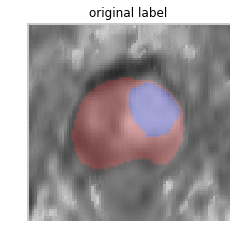

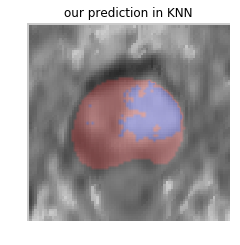

In [119]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title("original label")
plot_prediction(test_shape,test_sample,test_label,'0')
plt.figure(figsize=(8,4))
plt.subplot(122)
plt.title("our prediction in KNN")
plot_prediction(test_shape,test_sample,new_label_knn,'0')

In [120]:
#predict using SVM
MODE='SVM'
new_label_svm=predict_sample(test_sample,test_label,MODE=MODE,clf=svm_clf)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

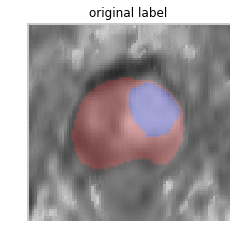

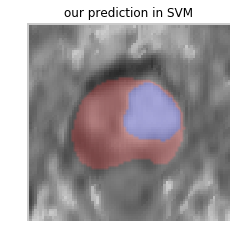

In [121]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title("original label")
plot_prediction(test_shape,test_sample,test_label,'0')
plt.figure(figsize=(8,4))
plt.subplot(122)
plt.title("our prediction in SVM")
plot_prediction(test_shape,test_sample,new_label_svm,'0')

In [136]:
#predict the in XGB
MODE='XGB'
new_label_xgb=predict_sample(test_sample,test_label,MODE=MODE,clf=xgb_clf)

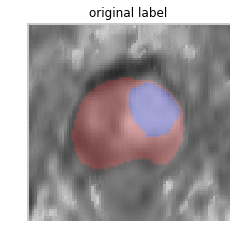

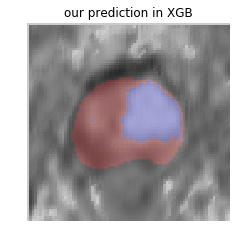

In [137]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title("original label")
plot_prediction(test_shape,test_sample,test_label,'0')
plt.figure(figsize=(8,4))
plt.subplot(122)
plt.title("our prediction in XGB")
plot_prediction(test_shape,test_sample,new_label_xgb,'0')

In [16]:
#the predicted label for Random forest and SVM
new_label=predict_sample(test_sample,test_label,rdf_clf)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

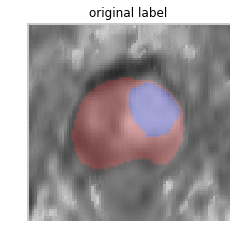

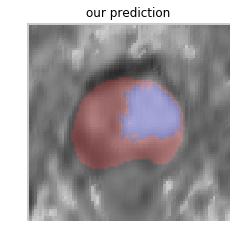

In [18]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title("original label")
plot_prediction(test_shape,test_sample,test_label,'0')
plt.figure(figsize=(8,4))
plt.subplot(122)
plt.title("our prediction")
plot_prediction(test_shape,test_sample,new_label,'0')

## 6.2 plot the decision boundary on 2 features

In [52]:
def plot_decision_boundary(test_sample,feature,clf):
    
    step=0.01
    f0_min,f0_max=test_sample.values[:,0].min(),test_sample.values[:,0].max()
    f1_min,f1_max=test_sample.values[:,1].min(),test_sample.values[:,1].max()
    f2_min,f2_max=test_sample.values[:,2].min(),test_sample.values[:,2].max()
    f3_min,f3_max=test_sample.values[:,3].min(),test_sample.values[:,3].max()
    f4_min,f4_max=test_sample.values[:,4].min(),test_sample.values[:,4].max()
    
    f_0,f_1=np.meshgrid(np.arange(f0_min,f0_max,step),np.arange(f1_min,f1_max,step))#,\
                     #np.arange(f2_min,f2_max,step),np.arange(f3_min,f3_max,step),\
                     #np.arange(f4_min,f4_max,step))
    return f_0
    
    
    
    
    

In [24]:
step=0.1
X_min,X_max=test_sample.values[:,0].min()-1,test_sample.values[:,0].max()+1
Y_min,Y_max=test_sample.values[:,3].min()-1,test_sample.values[:,1].max()+1
xx,yy=np.meshgrid(np.arange(X_min,X_max,step),np.arange(Y_min,Y_max,step))

X_grid=np.array([xx.ravel(),yy.ravel()]).T

In [25]:
X_grid.shape

(7308, 2)

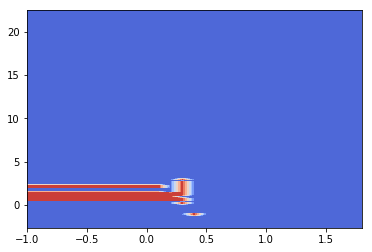

In [36]:
#nearst neighbour graph
X_predict=np.zeros((X_grid.shape[0],5))
X_predict[:,0]=X_grid[:,0]
X_predict[:,3]=X_grid[:,1]
X_predict[:,1],X_predict[:,2],X_predict[:,4]=1,1,2
Z=rdf_clf.predict(X_predict)
Z=Z.reshape(xx.shape)

plt.contourf(xx,yy,Z,cmap=plt.cm.coolwarm,alpha=1)

In [54]:
plot_decision_boundary(test_sample).shape

(2260, 89)

In [66]:
test_label.astype('int').values.ravel()

array([0, 0, 0, ..., 0, 0, 0])

In [36]:
sample=pd.concat([test_sample,new_label],axis=1)
set_1=sample.loc[sample['label']==1]
set_2=sample.loc[sample['label']==2]

In [41]:
test_sample.values.min()

-2.497139866393371